In [30]:
import pandas as pd
import numpy as np
import utilities as u
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [2]:
df_original = pd.read_csv("datasets/fires_dates_fixed.csv")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3147: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
columns = ["FIRE_NAME", "FIRE_YEAR", "FIRE_SIZE", "DISCOVERY_DATE", "CONT_DATE", "STAT_CAUSE_DESCR", "STATE", "COUNTY_NAME", "FIPS_STATE", "FIPS_CODE", "LATITUDE", "LONGITUDE", "CONT_TIME"]

In [4]:
df = df_original[columns]
df.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE,COUNTY_NAME,FIPS_STATE,FIPS_CODE,LATITUDE,LONGITUDE,CONT_TIME
0,TONSINA CREEK,2005,2.3,2005-04-28,2005-04-29,Campfire,Alaska,Kenai Peninsula,2,122,60.053333,-149.440000,2100.0
1,PETERSON CREEK,2005,2.5,2005-05-08,2005-05-10,Miscellaneous,Alaska,Kenai Peninsula,2,122,60.885000,-149.045000,1800.0
2,TWENTY MILE,2005,0.1,2005-05-09,2005-05-09,Debris Burning,Alaska,Kenai Peninsula,2,122,60.861667,-148.995000,1030.0
3,MOTORHOME,2007,0.1,2007-06-01,2007-06-01,Miscellaneous,Alaska,Kenai Peninsula,2,122,60.450278,-149.366944,1640.0
4,POWER,2007,0.1,2007-06-09,2007-06-09,Campfire,Alaska,Kenai Peninsula,2,122,60.466944,-149.700278,1450.0


## Number of Fires by Year

Seems to roughly match the statistics from https://fas.org/sgp/crs/misc/IF10244.pdf for the year 2015

In [5]:
fires_by_year = df.groupby("FIRE_YEAR")

In [6]:
#fires_by_year.size()

In [7]:
# Number of acres burned by year
acres_burned_by_year = df.groupby("FIRE_YEAR")
#acres_burned_by_year['FIRE_SIZE'].sum()

In [8]:
df_aqi = pd.read_csv("datasets/aqi.csv")

In [9]:
df_aqi['DATE'] = pd.to_datetime(df_aqi['DATE'])
df_aqi['DISCOVERY_DATE'] = df_aqi['DATE']

df_aqi.head()

,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,DISCOVERY_DATE
0,Alabama,Calhoun,1,15,1992-01-01,12,Good,PM10,01-015-0001,1,1992,1992-01-01
1,Alabama,Calhoun,1,15,1992-01-07,28,Good,PM10,01-015-0001,1,1992,1992-01-07
2,Alabama,Calhoun,1,15,1992-01-13,6,Good,PM10,01-015-0001,1,1992,1992-01-13
3,Alabama,Calhoun,1,15,1992-01-19,12,Good,PM10,01-015-0001,1,1992,1992-01-19
4,Alabama,Calhoun,1,15,1992-01-25,13,Good,PM10,01-015-0001,1,1992,1992-01-25


In [10]:
df_fires = df.groupby("FIRE_YEAR").get_group(2006)
df_fires = df_fires.dropna()
df_fires['DISCOVERY_DATE'] = pd.to_datetime(df_fires['DISCOVERY_DATE'])
df_fires['CONT_DATE'] = pd.to_datetime(df_fires['CONT_DATE'])

df_fires['DAYS'] =(df_fires['CONT_DATE'] - df_fires['DISCOVERY_DATE'])/np.timedelta64(1, 'D')
df_fires = df_fires.rename(columns={'FIPS_STATE':'STATE_CODE', 'FIPS_CODE':'COUNTY_CODE', 'STATE': 'STATE_NAME'})
df_fires.head()


,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME,COUNTY_NAME,STATE_CODE,COUNTY_CODE,LATITUDE,LONGITUDE,CONT_TIME,DAYS
30,HANGER FIRE,2006,0.1,2006-05-23,2006-05-23,Debris Burning,Alaska,Kenai Peninsula,2,122,60.526667,-149.515000,1500.0,0.0
31,DUNLEAVEY FIRE,2006,0.1,2006-05-25,2006-05-25,Debris Burning,Alaska,Kenai Peninsula,2,122,60.521667,-149.481667,815.0,0.0
32,FIRECRACKER,2006,0.1,2006-07-04,2006-07-04,Campfire,Alaska,Kenai Peninsula,2,122,60.483333,-149.906667,1415.0,0.0
33,GWINS FIRE,2006,0.1,2006-07-10,2006-07-10,Campfire,Alaska,Kenai Peninsula,2,122,60.493333,-149.906667,1655.0,0.0
34,MILE 15.5 FIRE,2006,0.1,2006-08-07,2006-08-08,Campfire,Alaska,Kenai Peninsula,2,122,60.303333,-149.363889,1000.0,1.0


In [11]:
col = []
for n in df_fires.index.values[0:10]:
    col.append(u.get_aqi_avg(df_aqi, df_fires.loc[n], [0, df_fires.loc[n].DAYS], 2006))
col

[8.0, None, 12.0, 10.0, None, 22.0, None, None, None, None]

In [12]:
## Experimenting
df_merged = pd.merge(df_fires,df_aqi, on=['STATE_CODE', 'COUNTY_CODE', 'DISCOVERY_DATE'])
df_merged = df_merged.dropna()
df_merged = df_merged[df_merged['FIRE_SIZE'] > 20]

In [13]:
#df_merged[0:3].apply(lambda r: u.get_aqi_change2(df_aqi, r, 2006),axis=1)
col = df_merged[0:2500].apply(lambda r: u.get_aqi_avg(df_aqi,r, [0, r.DAYS], 2006), axis=1)

In [14]:
df_small = pd.DataFrame(df_merged[0:2500])
df_small['AQI_AVG'] = col
df_small.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME_x,COUNTY_NAME_x,STATE_CODE,COUNTY_CODE,...,STATE_NAME_y,COUNTY_NAME_y,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,AQI_AVG
8,LAKE HOWARD,2006,21.7,2006-06-22,2006-07-01,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-06-22,90,Moderate,Ozone,01-121-0003,2,2006,81.0
10,MUMP CREEK,2006,57.0,2006-09-09,2006-09-11,Railroad,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-09-09,41,Good,Ozone,01-121-0003,1,2006,45.0
11,TALLADEGA MOUNTAIN,2006,84.0,2006-08-09,2006-08-12,Lightning,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-08-09,71,Moderate,Ozone,01-121-0003,1,2006,56.0
12,MITCHELL,2006,26.0,2006-03-16,2006-03-16,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-03-16,43,Good,Ozone,01-121-0003,1,2006,43.0
14,SYLACAUGA,2006,265.0,2006-03-17,2006-03-17,Arson,Alabama,Talladega,1,121,...,Alabama,Talladega,2006-03-17,38,Good,Ozone,01-121-0003,1,2006,38.0


Text(0, 0.5, 'Average AQI')

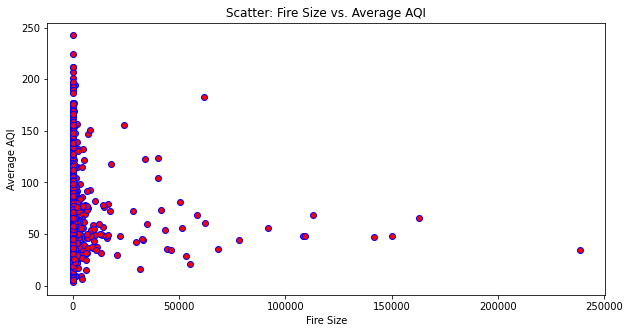

In [15]:
fig, ax1 = plt.subplots(1,1, figsize=(10, 5))

ax1.scatter(x=df_small['FIRE_SIZE'], y=df_small['AQI_AVG'], marker='o', c='r', edgecolor='b')
ax1.set_title('Scatter: Fire Size vs. Average AQI')
ax1.set_xlabel('Fire Size')
ax1.set_ylabel('Average AQI')

## Investigate Stated Causes of Fires

In [88]:
fires_2006 = fires_by_year.get_group(2006)
fires_1998 = fires_by_year.get_group(1998)

causes_2006 = fires_2006.groupby("STAT_CAUSE_DESCR")
causes_1998 = fires_1998.groupby("STAT_CAUSE_DESCR")

In [89]:
causes_1998.size().sort_values(ascending=False)

STAT_CAUSE_DESCR
Arson                4488
Debris Burning       4392
Lightning            4030
Miscellaneous        2786
Equipment Use        2265
Railroad             1393
Missing/Undefined    1200
Campfire             1021
Children              808
Smoking               802
Powerline             257
Fireworks             107
Structure              49
dtype: int64

In [90]:
causes_2006.size().sort_values(ascending=False)

STAT_CAUSE_DESCR
Debris Burning       22261
Miscellaneous        17147
Lightning            14172
Arson                13074
Equipment Use         7205
Missing/Undefined     6214
Smoking               2373
Children              2317
Campfire              2221
Railroad               901
Powerline              163
Fireworks               41
Structure               17
dtype: int64

### Top 20 state-counties with the most wildfires in 2006

In [91]:
# We can groupby FIPS_STATE and FIPS_CODE, but easier for humans to read if we groupby STATE, COUNTY_NAME
county_state_2006 = fires_2006.groupby(["STATE", "COUNTY_NAME"])
county_state_2006.size().sort_values(ascending=False)[:20]

STATE       COUNTY_NAME
New York    Suffolk        738
Arizona     Coconino       669
Hawaii      Honolulu       550
New York    Orange         381
Minnesota   St Louis       347
Texas       Atascosa       346
New York    Nassau         337
Oregon      Grant          333
Idaho       Idaho          325
Arizona     Mohave         318
New York    Erie           313
Texas       Wood           309
California  Riverside      308
New York    Monroe         305
Louisiana   Beauregard     300
Alabama     Mobile         297
Montana     Lincoln        292
Louisiana   St Tammany     289
Texas       Smith          283
California  Los Angeles    283
dtype: int64

Top 10 states with the most wildfires in 2006


In [92]:
# We can groupby FIPS_STATE and FIPS_CODE, but easier for humans to read if we groupby STATE, COUNTY_NAME
state_2006 = fires_2006.groupby(["STATE"])
state_2006.size().sort_values(ascending=False)[:10]

STATE
Texas             14597
Georgia            8868
New York           6610
North Carolina     5010
Florida            4723
Alabama            3936
California         3367
Oregon             3036
Louisiana          3013
South Carolina     2836
dtype: int64

In [104]:
# Top 10 states with most wildfires alltime 1992-2015
state = df.groupby(["STATE"])
state.size().sort_values(ascending=False)[:10]

STATE
Georgia           150234
Texas             136462
Florida            83601
New York           80018
California         56221
South Carolina     53341
Mississippi        48295
North Carolina     47592
Alabama            41560
Oregon             40178
dtype: int64

### States with most acres burned based on fire size

In [105]:
state["FIRE_SIZE"].sum().sort_values(ascending=False)[:20]

STATE
Idaho          9.591734e+06
Texas          7.953988e+06
Nevada         7.421757e+06
California     6.524384e+06
Oregon         5.792585e+06
New Mexico     4.187921e+06
Montana        3.628712e+06
Washington     3.057350e+06
Florida        3.032167e+06
Utah           2.886954e+06
Arizona        2.553902e+06
Alaska         2.285323e+06
Oklahoma       1.530667e+06
Wyoming        1.501708e+06
Colorado       1.208078e+06
Minnesota      8.183956e+05
Kansas         7.970291e+05
Georgia        7.519269e+05
Mississippi    7.162935e+05
Alabama        5.979095e+05
Name: FIRE_SIZE, dtype: float64

### California acres burned by year

In [117]:
CA = df[df["STATE"] == "California"]
AL = df[df["STATE"] == "Alaska"]
ID = df[df["STATE"] == "Idaho"]

In [113]:
CA.groupby("FIRE_YEAR")["FIRE_SIZE"].sum()

FIRE_YEAR
1997         14.90
1998      15709.70
1999      73361.80
2000      41184.70
2001      95824.30
2002     138900.50
2003     283607.74
2004      95108.67
2005      60821.50
2006     672051.94
2007     910144.52
2008    1176897.80
2009     356014.33
2010      81301.26
2011      84625.69
2012     711661.13
2013     544348.06
2014     507431.63
2015     675373.61
Name: FIRE_SIZE, dtype: float64

In [116]:
AL.groupby("FIRE_YEAR")["FIRE_SIZE"].sum()

FIRE_YEAR
1997          2.00
2004          0.50
2005        353.25
2006          5.20
2007          4.00
2008          1.20
2009         22.27
2010         14.10
2012          1.20
2013        136.10
2014     198275.08
2015    2086507.76
Name: FIRE_SIZE, dtype: float64

In [118]:
ID.groupby("FIRE_YEAR")["FIRE_SIZE"].sum()

FIRE_YEAR
1992       3196.00
1993        842.70
1994      11735.00
1995       1545.60
1996      27623.10
1997       1432.30
1998       9781.60
1999     382231.42
2000     589100.98
2001     163844.82
2002      72382.15
2003     201862.93
2004      11709.78
2005     600871.83
2006     903992.13
2007    2068452.94
2008     168701.06
2009      23432.81
2010     642887.96
2011     232460.61
2012    1772657.44
2013     738809.00
2014     195085.87
2015     767094.21
Name: FIRE_SIZE, dtype: float64

### For 2006, group by state, county, and date

In [124]:
state_county_date = fires_2006.groupby(["STATE", "COUNTY_NAME", "DISCOVERY_DATE"])

In [129]:
state_county_date.size()

STATE    COUNTY_NAME  DISCOVERY_DATE
Alabama  Autauga      2006-01-04        1
                      2006-01-07        2
                      2006-01-08        2
                      2006-01-16        4
                      2006-01-26        1
                                       ..
Wyoming  Weston       2006-06-11        1
                      2006-07-06        1
                      2006-07-12        1
                      2006-07-30        1
                      2006-08-08        1
Length: 57652, dtype: int64

### For 2006, list counties that had the most fires reported in a single day

In [133]:
state_county_date.size().sort_values(ascending=False)[:10]

STATE       COUNTY_NAME  DISCOVERY_DATE
Oregon      Grant        2006-08-08        55
New York    Orange       2006-04-12        53
Hawaii      Honolulu     2006-07-04        47
Oregon      Klamath      2006-08-06        42
California  Siskiyou     2006-08-07        37
                         2006-07-24        34
Idaho       Idaho        2006-08-09        33
California  Trinity      2006-08-07        30
Louisiana   Beauregard   2006-03-26        29
Oregon      Jackson      2006-08-06        28
dtype: int64

### K-Means Clustering

In [98]:
# by fire: latitude, longitude, cont time, aqi/avg_aqi, days, fire_size
# alt: by county: avg aqi, mcc, acres burned by state, # of fires per county
columns = ["LATITUDE", "LONGITUDE", "CONT_TIME", "AQI_AVG", "DAYS", "FIRE_SIZE"]
df_new = df_small[columns]
df_new.head()

,LATITUDE,LONGITUDE,CONT_TIME,AQI_AVG,DAYS,FIRE_SIZE
8,33.208889,-86.208889,1600.0,81.0,9.0,21.7
10,33.371111,-86.018056,1602.0,45.0,2.0,57.0
11,33.332778,-86.007222,1200.0,56.0,3.0,84.0
12,33.537500,-85.819167,1030.0,43.0,0.0,26.0
14,33.247586,-86.371107,1729.0,38.0,0.0,265.0


In [99]:
X_std = StandardScaler().fit_transform(df_new)

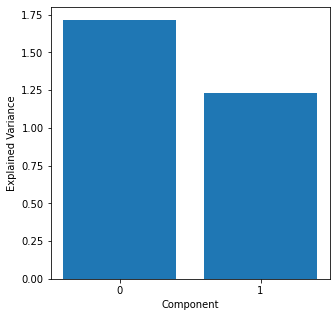

In [100]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(X_std)

f = range(pca.n_components_)
plt.figure(figsize=(5,5))
plt.bar(f, pca.explained_variance_)
plt.xticks(f)
plt.ylabel('Explained Variance')
plt.xlabel('Component')
plt.show()

In [101]:
pca_data = pca.transform(X_std)
df_pca = pd.DataFrame(pca_data)

In [102]:
# Fit Kmeans and calculate SSE for each k value
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_pca)
    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

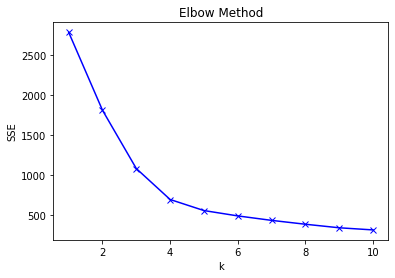

In [103]:
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.show()

In [104]:
## Elbow at K = 4
kmeans = KMeans(n_clusters=4, random_state=614)
kmeans.fit(pca_data)
df_pca = df_pca.assign(cluster=kmeans.labels_)
df_kmeans = df_small.assign(cluster=kmeans.labels_)

In [105]:
df_kmeans.head()

,FIRE_NAME,FIRE_YEAR,FIRE_SIZE,DISCOVERY_DATE,CONT_DATE,STAT_CAUSE_DESCR,STATE_NAME_x,COUNTY_NAME_x,STATE_CODE,COUNTY_CODE,...,COUNTY_NAME_y,DATE,AQI,CATEGORY,DEFINING_PARAMETER,DEFINING_SITE,NUMBER_OF_SITES_REPORTING,YEAR,AQI_AVG,cluster
8,LAKE HOWARD,2006,21.7,2006-06-22,2006-07-01,Arson,Alabama,Talladega,1,121,...,Talladega,2006-06-22,90,Moderate,Ozone,01-121-0003,2,2006,81.0,1
10,MUMP CREEK,2006,57.0,2006-09-09,2006-09-11,Railroad,Alabama,Talladega,1,121,...,Talladega,2006-09-09,41,Good,Ozone,01-121-0003,1,2006,45.0,1
11,TALLADEGA MOUNTAIN,2006,84.0,2006-08-09,2006-08-12,Lightning,Alabama,Talladega,1,121,...,Talladega,2006-08-09,71,Moderate,Ozone,01-121-0003,1,2006,56.0,1
12,MITCHELL,2006,26.0,2006-03-16,2006-03-16,Arson,Alabama,Talladega,1,121,...,Talladega,2006-03-16,43,Good,Ozone,01-121-0003,1,2006,43.0,1
14,SYLACAUGA,2006,265.0,2006-03-17,2006-03-17,Arson,Alabama,Talladega,1,121,...,Talladega,2006-03-17,38,Good,Ozone,01-121-0003,1,2006,38.0,1


In [106]:
df_kmeans.cluster.value_counts() ## dominance of one cluster, but that's ok.

0    483
2    185
1    154
3    124
Name: cluster, dtype: int64

Text(0.5, 1.0, 'PCA1 vs. PCA2')

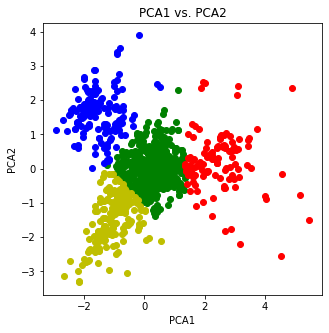

In [107]:
pca_arr = df_pca.values
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
plt.scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
plt.scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
plt.scatter(pca_arr[kmeans.labels_ == 3,0], pca_arr[kmeans.labels_ == 3,1], c= 'r', label="Cluster 4")
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('PCA1 vs. PCA2')



In [108]:
# by fire: latitude, longitude, cont time, aqi/avg_aqi, days, fire_size
# alt: by county: avg aqi, mcc, acres burned by state, # of fires per county
columns = ["FIRE_SIZE", "AQI_AVG"]
df_new = df_small[columns]
df_new.head()

,FIRE_SIZE,AQI_AVG
8,21.7,81.0
10,57.0,45.0
11,84.0,56.0
12,26.0,43.0
14,265.0,38.0


In [109]:
# Fit Kmeans and calculate SSE for each k value
sse = {}
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=1)
    kmeans.fit(df_new)
    sse[k] = kmeans.inertia_ # sum of squared distances to the closest cluster centers

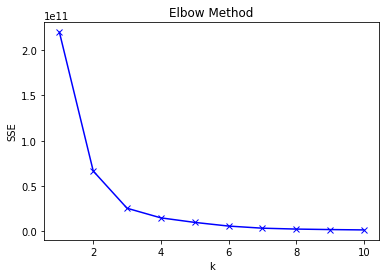

In [110]:
plt.title('Elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
plt.plot(list(sse.keys()), list(sse.values()), 'bx-')
plt.show()

In [115]:
## Elbow at K = 3
kmeans = KMeans(n_clusters=3, random_state=1)
kmeans.fit(df_new)
df_kmeans = df_new.assign(cluster=kmeans.labels_)

Text(0.5, 1.0, 'K-Means Analysis')

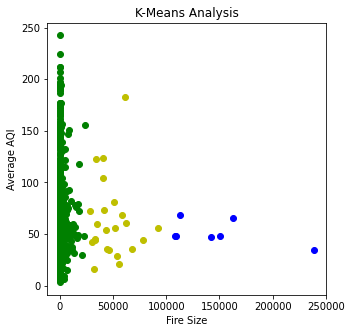

In [116]:
pca_arr = df_kmeans.values
fig, ax = plt.subplots(figsize=(5,5))
plt.scatter(pca_arr[kmeans.labels_ == 0,0], pca_arr[kmeans.labels_ == 0,1], c= 'g', label="Cluster 1")
plt.scatter(pca_arr[kmeans.labels_ == 1,0], pca_arr[kmeans.labels_ == 1,1], c= 'b', label="Cluster 2")
plt.scatter(pca_arr[kmeans.labels_ == 2,0], pca_arr[kmeans.labels_ == 2,1], c= 'y', label="Cluster 3")
#plt.scatter(pca_arr[kmeans.labels_ == 3,0], pca_arr[kmeans.labels_ == 3,1], c= 'r', label="Cluster 4")
plt.xlabel('Fire Size')
plt.ylabel('Average AQI')
plt.title('K-Means Analysis')

